In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import pickle

tf_2_genes_path = '../miner2/miner2/data/tfbsdb_tf_to_genes.pkl' # location of tfbs_db
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.25.0 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
def get_gene_set():
    # get all unique gene Ensembl ids from tfbsdb database
    with open(tf_2_genes_path, 'rb') as f:
        tf_2_genes = pickle.load(f)
    
    gene_set = set()
    for key in tf_2_genes:
        value = tf_2_genes[key]
        gene_set.add(key)
        gene_set.update(value)
    return gene_set

def get_ensembl_protein_coding_genes():
    ensembl_df = pd.read_csv('/home/aliu/Projects/causalAssociation/src/mart_export.txt', sep=',', header = 0, index_col = None, engine='python')
    return set(ensembl_df['Gene name']), set(ensembl_df['Gene stable ID'])

def cmp_to_key(mycmp):
    'Convert a cmp= function into a key= function'
    class K:
        def __init__(self, obj, *args):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0
        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0
        def __ne__(self, other):
            return mycmp(self.obj, other.obj) != 0
    return K

def comparator(x, y):
    if (x[1][0] != y[1][0]):
        return x[1][0] - y[1][0]
    return x[1][1] - y[1][1]

def select_ensembl_id(gene_ids):
    # select single ensembl_id from list of ensembl_ids
    for gene_id in gene_ids:
        if gene_id not in ensembl_id_set or gene_id not in gene_set:
            gene_ids.remove(gene_id)
            
    if len(gene_ids) == 0:
        return None
    elif len(gene_ids) == 1:
        return gene_ids[0]
            
    with open(tf_2_genes_path, 'rb') as f:
        tf_2_genes = pickle.load(f)
    
    tracker = {} # count number of times gene id is tf or affected by tf
    for gene_id in gene_ids:
        tracker[gene_id] = [0,0] #[tf, affected by tf]
    for key in tf_2_genes:
        if key in tracker:
            tracker[gene_id][0] += 1
        for affected_gene in tf_2_genes[key]:
            if affected_gene in tracker:
                tracker[affected_gene][1] += 1
    
    # return most active gene id in tfbsdb
    sorted_genes = sorted(tracker.items(), key=cmp_to_key(comparator)) 
    # print(sorted_genes)

    return sorted_genes[-1][0]
    
gene_set = get_gene_set()
gene_name_set, ensembl_id_set = get_ensembl_protein_coding_genes()

In [3]:
df = pd.read_csv('/home/aliu/omics4tb2/aliu/projects/causalAssociation/results/expected/GSM3587977_AML707B-D97.dem.txt', sep='\t', header = 0, index_col = 0, engine='python')
#df[df.index.str.match('RNA')]
# # write all gene ids to gene_names.txt
# gene_ids = df.index.tolist()
# with open('./gene_names.txt', 'a+') as file:
#     for item in gene_ids:
#         file.write("%s\n" % item)


# selected_genes = []
# new_genes_index = []   
# ### use https://biodbnet-abcc.ncifcrf.gov/db/db2db.php to get ensembl gene id for gene symbol
# df_gene_conversion = pd.read_csv('/home/aliu/Projects/causalAssociation/src/gene_symbol_to_ensembl.txt', sep='\t', header = 0, index_col = 0, engine='python')

# for gene in df.index:
#     ensembl_id = df_gene_conversion.loc[gene]['Ensembl Gene ID']
#     if ensembl_id == '-' or gene not in gene_name_set:
#         continue
#     if ";" in ensembl_id:
#         ensembl_id_list = ensembl_id.split('; ')
#         ensembl_id = select_ensembl_id(ensembl_id_list)
#     if ensembl_id == None:
#         continue
#     selected_genes.append(gene)
#     new_genes_index.append(ensembl_id)

In [4]:
# # gene symbol to ensembl id mapping
# gs_to_ensembl = pd.DataFrame(data = {'Gene Symbol': selected_genes, 'Ensembl Id': new_genes_index})
# gs_to_ensembl = gs_to_ensembl.set_index('Gene Symbol')
# gs_to_ensembl.loc[gs_to_ensembl['Ensembl Id'] == 'ENSG00000234906']

# ### manual fix
# gs_to_ensembl.at['AMELX','Ensembl Id'] = 'ENSG00000125363'
# gs_to_ensembl.at['AMELY','Ensembl Id'] = 'ENSG00000099721'
# gs_to_ensembl.at['APOC2','Ensembl Id'] = 'ENSG00000234906'
# gs_to_ensembl.at['APOC4-APOC2','Ensembl Id'] = 'ENSG00000224916'
# gs_to_ensembl.at['BORCS7','Ensembl Id'] = 'ENSG00000166275'
# gs_to_ensembl.at['BORCS7-ASMT','Ensembl Id'] = 'ENSG00000270316'
# gs_to_ensembl.at['CCL15','Ensembl Id'] = 'ENSG00000275718'
# gs_to_ensembl.at['CCL15-CCL14','Ensembl Id'] = 'ENSG00000275688'
# gs_to_ensembl.at['CCL3L1','Ensembl Id'] = 'ENSG00000276085'
# gs_to_ensembl.at['CCL3L3','Ensembl Id'] = 'ENSG00000277336' # alternative sequence
# gs_to_ensembl.at['DEFB105A','Ensembl Id'] = 'ENSG00000186562'
# gs_to_ensembl.at['DEFB105B','Ensembl Id'] = 'ENSG00000186599'
# gs_to_ensembl.at['DEFB107A','Ensembl Id'] = 'ENSG00000186572'
# gs_to_ensembl.at['DEFB107B','Ensembl Id'] = 'ENSG00000198129'
# gs_to_ensembl.at['BIVM-ERCC5','Ensembl Id'] = 'ENSG00000270181'
# gs_to_ensembl.at['ERCC5','Ensembl Id'] = 'ENSG00000134899'
# gs_to_ensembl.at['CCDC103','Ensembl Id'] = 'ENSG00000167131'
# gs_to_ensembl.at['FAM187A','Ensembl Id'] = 'ENSG00000214447'
# gs_to_ensembl.at['CHURC1-FNTB','Ensembl Id'] = 'ENSG00000125954'
# gs_to_ensembl.at['FNTB','Ensembl Id'] = 'ENSG00000257365'
# gs_to_ensembl.at['GAGE12J','Ensembl Id'] = 'ENSG00000224659'
# gs_to_ensembl.at['GAGE2E','Ensembl Id'] = 'ENSG00000275113'
# gs_to_ensembl.at['GAGE12B','Ensembl Id'] = 'ENSG00000236737'
# gs_to_ensembl.at['CERS1','Ensembl Id'] = 'ENSG00000223802'
# gs_to_ensembl.at['GDF1','Ensembl Id'] = 'ENSG00000130283'
# gs_to_ensembl.at['ARMCX5-GPRASP2','Ensembl Id'] = 'ENSG00000271147'
# gs_to_ensembl.at['GPRASP2','Ensembl Id'] = 'ENSG00000158301'
# gs_to_ensembl.at['H2AFB2','Ensembl Id'] = 'ENSG00000277858'
# gs_to_ensembl.at['H2AFB3','Ensembl Id'] = 'ENSG00000277745'
# gs_to_ensembl.at['H3F3A','Ensembl Id'] = 'ENSG00000163041'
# gs_to_ensembl.at['H3F3B','Ensembl Id'] = 'ENSG00000132475'
# gs_to_ensembl.at['HIST1H2AB','Ensembl Id'] = 'ENSG00000278463'
# gs_to_ensembl.at['HIST1H2AE','Ensembl Id'] = 'ENSG00000277075'
# gs_to_ensembl.at['HIST1H2AG','Ensembl Id'] = 'ENSG00000196787'
# gs_to_ensembl.at['HIST1H2AI','Ensembl Id'] = 'ENSG00000196747'
# gs_to_ensembl.at['HIST1H2AK','Ensembl Id'] = 'ENSG00000275221'
# gs_to_ensembl.at['HIST1H2AL','Ensembl Id'] = 'ENSG00000276903'
# gs_to_ensembl.at['HIST1H2AM','Ensembl Id'] = 'ENSG00000278677'
# gs_to_ensembl.at['HIST1H2BC','Ensembl Id'] = 'ENSG00000180596'
# gs_to_ensembl.at['HIST1H2BE','Ensembl Id'] = 'ENSG00000274290'
# gs_to_ensembl.at['HIST1H2BF','Ensembl Id'] = 'ENSG00000277224'
# gs_to_ensembl.at['HIST1H2BG','Ensembl Id'] = 'ENSG00000273802'
# gs_to_ensembl.at['HIST1H2BI','Ensembl Id'] = 'ENSG00000278588'
# gs_to_ensembl.at['HIST1H3A','Ensembl Id'] = 'ENSG00000275714'
# gs_to_ensembl.at['HIST1H3B','Ensembl Id'] = 'ENSG00000286522'
# gs_to_ensembl.at['HIST1H3C','Ensembl Id'] = 'ENSG00000287080'
# gs_to_ensembl.at['HIST1H3D','Ensembl Id'] = 'ENSG00000197409'
# gs_to_ensembl.at['HIST1H3E','Ensembl Id'] = 'ENSG00000274750'
# gs_to_ensembl.at['HIST1H3F','Ensembl Id'] = 'ENSG00000277775'
# gs_to_ensembl.at['HIST1H3G','Ensembl Id'] = 'ENSG00000273983'
# gs_to_ensembl.at['HIST1H3H','Ensembl Id'] = 'ENSG00000278828'
# gs_to_ensembl.at['HIST1H3I','Ensembl Id'] = 'ENSG00000275379'
# gs_to_ensembl.at['HIST1H3J','Ensembl Id'] = 'ENSG00000197153'
# gs_to_ensembl.at['ARL17A','Ensembl Id'] = 'ENSG00000185829'
# gs_to_ensembl.at['ARL17B','Ensembl Id'] = 'ENSG00000228696'
# gs_to_ensembl.at['CBWD3','Ensembl Id'] = 'ENSG00000196873'
# gs_to_ensembl.at['CBWD5','Ensembl Id'] = 'ENSG00000147996'
# gs_to_ensembl.at['DDT','Ensembl Id'] = 'ENSG00000099977'
# gs_to_ensembl.at['DDTL','Ensembl Id'] = 'ENSG00000099974'
# gs_to_ensembl.at['DEFB103A','Ensembl Id'] = 'ENSG00000176797'
# gs_to_ensembl.at['DEFB103B','Ensembl Id'] = 'ENSG00000177243'
# gs_to_ensembl.at['GARS','Ensembl Id'] = 'ENSG00000106105'
# gs_to_ensembl.at['GART','Ensembl Id'] = 'ENSG00000159131'
# gs_to_ensembl.at['HIST1H4A','Ensembl Id'] = 'ENSG00000278637'
# gs_to_ensembl.at['HIST1H4B','Ensembl Id'] = 'ENSG00000278705'
# gs_to_ensembl.at['HIST1H4C','Ensembl Id'] = 'ENSG00000197061'
# gs_to_ensembl.at['HIST1H4D','Ensembl Id'] = 'ENSG00000277157'
# gs_to_ensembl.at['HIST1H4E','Ensembl Id'] = 'ENSG00000276966'
# gs_to_ensembl.at['HIST1H4F','Ensembl Id'] = 'ENSG00000274618'
# gs_to_ensembl.at['HIST1H4H','Ensembl Id'] = 'ENSG00000158406'
# gs_to_ensembl.at['HIST1H4I','Ensembl Id'] = 'ENSG00000276180'
# gs_to_ensembl.at['HIST1H4J','Ensembl Id'] = 'ENSG00000197238'
# gs_to_ensembl.at['HIST1H4K','Ensembl Id'] = 'ENSG00000273542'
# gs_to_ensembl.at['HIST1H4L','Ensembl Id'] = 'ENSG00000275126'
# gs_to_ensembl.at['HIST2H4A','Ensembl Id'] = 'ENSG00000270882'
# gs_to_ensembl.at['HIST2H4B','Ensembl Id'] = 'ENSG00000270276'
# gs_to_ensembl.at['HIST4H4','Ensembl Id'] = 'ENSG00000197837'
# gs_to_ensembl.at['HIST2H2AA3','Ensembl Id'] = 'ENSG00000203812'
# gs_to_ensembl.at['HIST2H2AA4','Ensembl Id'] = 'ENSG00000272196'
# gs_to_ensembl.at['HIST2H3A','Ensembl Id'] = 'ENSG00000203852'
# gs_to_ensembl.at['HIST2H3C','Ensembl Id'] = 'ENSG00000203811'
# gs_to_ensembl.at['HIST2H3D','Ensembl Id'] = 'ENSG00000183598'
# gs_to_ensembl.at['GALNT8','Ensembl Id'] = 'ENSG00000130035'
# gs_to_ensembl.at['KCNA6','Ensembl Id'] = 'ENSG00000151079'
# gs_to_ensembl.at['KIR2DL5A','Ensembl Id'] = 'ENSG00000274143'
# gs_to_ensembl.at['KIR2DS5','Ensembl Id'] = 'ENSG00000274739' # alternative sequence
# gs_to_ensembl.at['KLRC4-KLRK1','Ensembl Id'] = 'ENSG00000255819'
# gs_to_ensembl.at['KLRK1','Ensembl Id'] = 'ENSG00000213809'
# gs_to_ensembl.at['CRHR1','Ensembl Id'] = 'ENSG00000120088'
# gs_to_ensembl.at['LINC02210-CRHR1','Ensembl Id'] = 'ENSG00000263715'
# gs_to_ensembl.at['BORCS8-MEF2B','Ensembl Id'] = 'ENSG00000064489'
# gs_to_ensembl.at['MEF2B','Ensembl Id'] = 'ENSG00000213999'
# gs_to_ensembl.at['BUB1B-PAK6','Ensembl Id'] = 'ENSG00000259288'
# gs_to_ensembl.at['PAK6','Ensembl Id'] = 'ENSG00000137843'
# gs_to_ensembl.at['PALM2','Ensembl Id'] = 'ENSG00000243444'
# gs_to_ensembl.at['PALM2-AKAP2','Ensembl Id'] = 'ENSG00000157654'
# gs_to_ensembl.at['PRAMEF25','Ensembl Id'] = 'ENSG00000229571'
# gs_to_ensembl.at['PRAMEF26','Ensembl Id'] = 'ENSG00000280267'
# gs_to_ensembl.at['EPRS','Ensembl Id'] = 'ENSG00000136628'
# gs_to_ensembl.at['QARS','Ensembl Id'] = 'ENSG00000172053'
# gs_to_ensembl.at['GPR21','Ensembl Id'] = 'ENSG00000188394'
# gs_to_ensembl.at['RABGAP1','Ensembl Id'] = 'ENSG00000011454'
# gs_to_ensembl.at['FSBP','Ensembl Id'] = 'ENSG00000265817'
# gs_to_ensembl.at['RAD54B','Ensembl Id'] = 'ENSG00000197275'
# gs_to_ensembl.at['RLN1','Ensembl Id'] = 'ENSG00000107018'
# gs_to_ensembl.at['RLN2','Ensembl Id'] = 'ENSG00000107014'
# gs_to_ensembl.at['IQCJ-SCHIP1','Ensembl Id'] = 'ENSG00000283154'
# gs_to_ensembl.at['SCHIP1','Ensembl Id'] = 'ENSG00000151967'
# gs_to_ensembl.at['MARS','Ensembl Id'] = 'ENSG00000166986'
# gs_to_ensembl.at['SLA2','Ensembl Id'] = 'ENSG00000101082'
# gs_to_ensembl.at['TBC1D3','Ensembl Id'] = 'ENSG00000274611'
# gs_to_ensembl.at['TBC1D3L','Ensembl Id'] = 'ENSG00000274512'
# gs_to_ensembl.at['TP53TG3D','Ensembl Id'] = 'ENSG00000205456'
# gs_to_ensembl.at['TP53TG3E','Ensembl Id'] = 'ENSG00000275034'
# gs_to_ensembl.at['TP53TG3F','Ensembl Id'] = 'ENSG00000278848'
# gs_to_ensembl.at['ZNF320','Ensembl Id'] = 'ENSG00000182986'
# gs_to_ensembl.at['ZNF468','Ensembl Id'] = 'ENSG00000204604'


# df = df.loc[gs_to_ensembl.index]
# df.index = gs_to_ensembl['Ensembl Id']

In [5]:
# write out preprocessed digital expression matrix
dfTranspose = df.T
dfTranspose.to_csv('/home/aliu/omics4tb2/aliu/projects/causalAssociation/results/expected/GSM3587977_AML707B-D97.transpose.dem.txt', sep='\t')

In [6]:
# import data as AnnData
adata = sc.read_csv('/home/aliu/omics4tb2/aliu/projects/causalAssociation/results/expected/GSM3587977_AML707B-D97.transpose.dem.txt', delimiter='\t', )
adata

AnnData object with n_obs × n_vars = 84 × 27899 

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


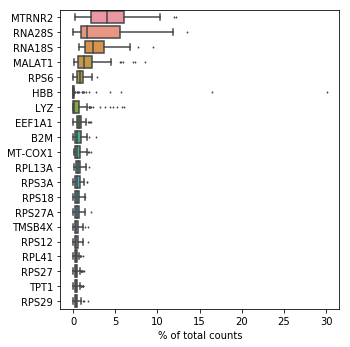

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 20962 genes that are detectedin less than 3 cells


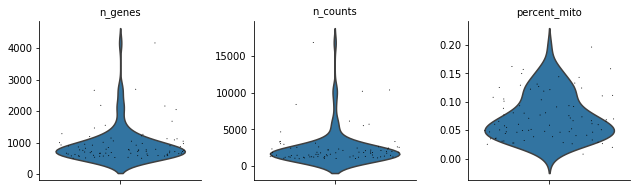

In [9]:
mito_genes = adata.var_names.str.startswith('MT')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

# create violin plot
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

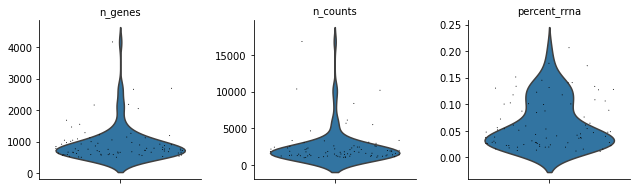

In [10]:
rrna_transcript = adata.var_names.str.startswith('RNA')
# for each cell compute fraction of counts in rrna transcripts vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_rrna'] = np.sum(
    adata[:, rrna_transcript].X, axis=1) / np.sum(adata.X, axis=1)

# create violin plot
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_rrna'],
             jitter=0.4, multi_panel=True)

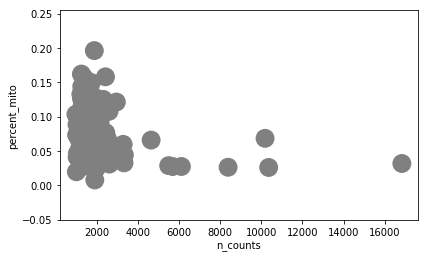

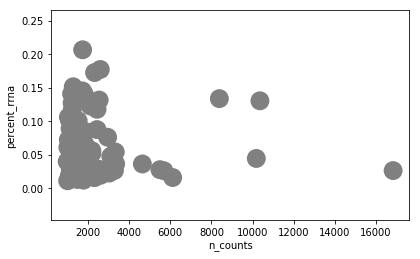

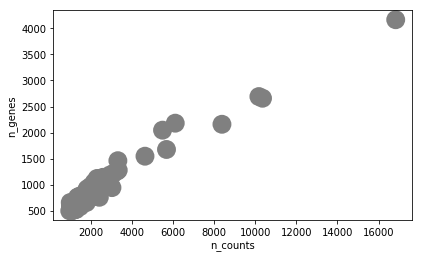

In [11]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='percent_rrna')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [12]:
# filter out cells with high mito gene expression or not many genes expressed
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]
adata = adata[adata.obs['percent_rrna'] < 0.15, :]

In [13]:
# normalize total counts in each cell to 10,000 so that cells are comparable
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# log
sc.pp.log1p(adata)
# freeze state of adata object
adata.raw = adata

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


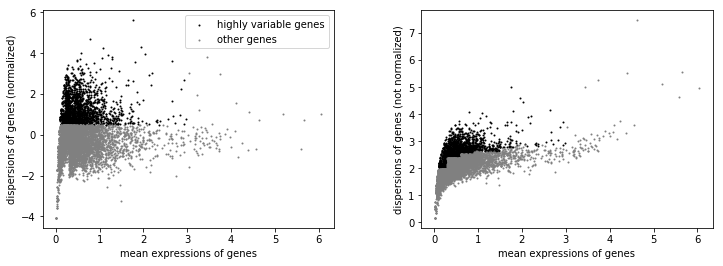

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [15]:
# filter out non highly variable genes
adata = adata[:, adata.var['highly_variable']]

sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.regress_out(adata, ['n_counts', 'percent_rrna'])

regressing out ['n_counts', 'percent_mito']
    finished (0:00:02)
regressing out ['n_counts', 'percent_rrna']
    finished (0:00:02)


In [16]:
# scale each gene to unit variance, max value set to 10
sc.pp.scale(adata, max_value=10)

computing PCA with n_comps = 30
computing PCA on highly variable genes
    finished (0:00:00)


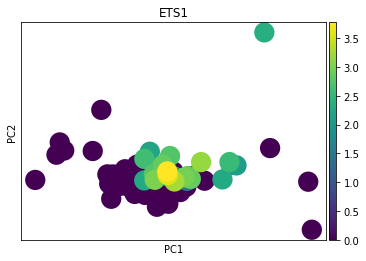

In [17]:
# PCA analysis
sc.tl.pca(adata, svd_solver='arpack', n_comps = 30)
sc.pl.pca(adata, color='ETS1')

In [18]:
adata

AnnData object with n_obs × n_vars = 73 × 1871 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'percent_rrna'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

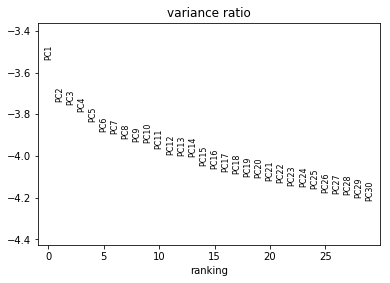

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


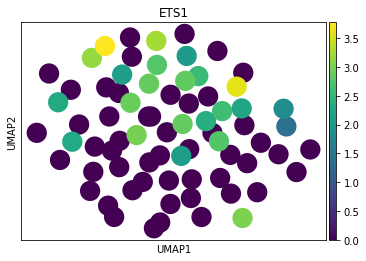

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 2 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


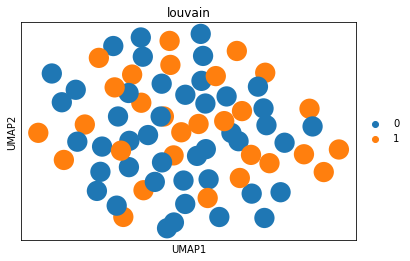

In [27]:
sc.pp.neighbors(adata,n_neighbors=50,n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color='ETS1',palette='viridis')
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'])

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


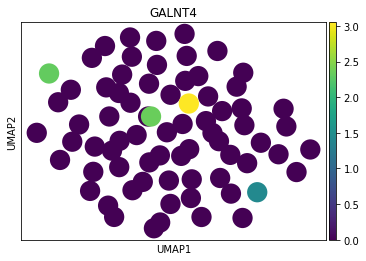

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 2 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


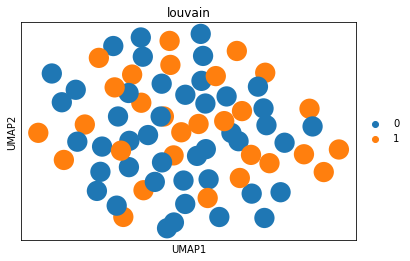

In [39]:
sc.pp.neighbors(adata,n_neighbors=50,n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color='GALNT4',palette='viridis')
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'])

In [21]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 73 × 1871 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'percent_rrna', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'